In [1]:
#! /usr/bin/env python
# -*- encoding UTF-8 -*-

import os
import sys
from importlib import reload
reload(sys)

if sys.version[0] == '2':
    sys.setdefaultencoding("utf-8")
    
    import parse
    import urllib2
else:
    import urllib.parse
    from urllib.request import urlopen

import re
import jieba

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import ChromeOptions

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

jieba.enable_paddle()

Paddle enabled successfully......


In [2]:
def dateConvert(news_date):
    news_date = str(news_date)
    news_date = news_date.replace('00:00:00','')
    news_date = news_date.replace('-','')
    news_date = news_date.strip()
    
    return news_date

In [3]:
def cleanHTML(html):
    for script in html(["script", "style"]): # remove all javascript and stylesheet code
        script.extract()
    # get text
    text = html.get_text()
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    
    return text

In [4]:
def cleanText(text):
    if ("攝）" in text):
        text = ''
        
    if ("（無綫畫面）" in text):
        text = ''
        
    text = text.replace('第一手消息請下載on.cc東網iPhone/iPad/Android/Windows Phone Apps','')
        
    return text

In [5]:
def getNewsLink(news_date):
    try:
        options = ChromeOptions()
        options.add_argument('headless')
        driver = webdriver.Chrome(options=options)

        url = 'https://orientaldaily.on.cc/cnt/news/' + str(news_date) + '/mobile/index.html'

        driver.get(url)
        driver.implicitly_wait(30)

        html_source = (driver.page_source.encode('utf-8'))

        driver.quit()

        soup = BeautifulSoup(html_source, 'html.parser')
        news = soup.find('div', attrs={'id':'swipe'})
        main_focus = soup.find('div', attrs={'class':'main-focus-container'})
        main_focus_link = 'https://orientaldaily.on.cc' + main_focus.find('a', href = re.compile(r'[/]([a-z]|[A-Z])\w+')).attrs['href']

        return (main_focus_link)
    except:
        return 0

In [6]:
def getNews(news_url):
    options = ChromeOptions()
    options.add_argument('headless')
    driver = webdriver.Chrome(options=options)
    
    driver.get(news_url)
    driver.implicitly_wait(30)
        
    html_source = (driver.page_source.encode('utf-8'))
        
    driver.quit()
    
    soup = BeautifulSoup(html_source, 'html.parser')
    paragraph = soup.find_all('div', attrs={'class':'paragraph'})
    paragraph_list = []
    
    for sub_paragraph in paragraph:
        clean_sub_paragraph = cleanHTML(sub_paragraph)
        paragraph_list.append(clean_sub_paragraph)
        
    full_paragraph_list = [e for e in paragraph_list if e]
    
    if (len(full_paragraph_list) > 0):
        f=open("news.txt", "a+")
        
        for i in range(len(full_paragraph_list)):
            
            
            for line in full_paragraph_list[i].splitlines():
                clean_paragraph = cleanText(line)
                
                f.write(clean_paragraph)
                
        f.write('\n\n')
        f.close()

In [7]:
def draw_word_cloud(text, images_name, plt_title):
    #https://medium.com/the-artificial-impostor/nlp-four-ways-to-tokenize-chinese-documents-f349eb6ba3c3
    images_path = images_name
    images = Image.open(images_path)
    
    #create a write mask 
    images_mask = Image.new("RGB", images.size, (255,255,255))
    images_mask.paste(images, images)
    images_mask = np.array(images_mask)
    
    color = ImageColorGenerator(images_mask)
    
    #Chinese need to use another font, download it from https://www.freechinesefont.com/
    font_path = 'HanyiSentyCandy.ttf'
    
    #create wordcloud ~ https://amueller.github.io/word_cloud/index.html
    wc = WordCloud(font_path=font_path, max_font_size=250, max_words=1000, mask=images_mask, \
                   margin=5, background_color="black").generate_from_text(text)
    wc.recolor(color_func = color, random_state = 7)
    
    #Save the image
    wc.to_file("news.png")
    
    plt.rcParams["figure.figsize"] = (16, 12)
    
    plt.title(plt_title)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Enter the start date (yyyymmdd): 20200101
Enter the end date (yyyymmdd): 20200525


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.580 seconds.
Prefix dict has been built successfully.


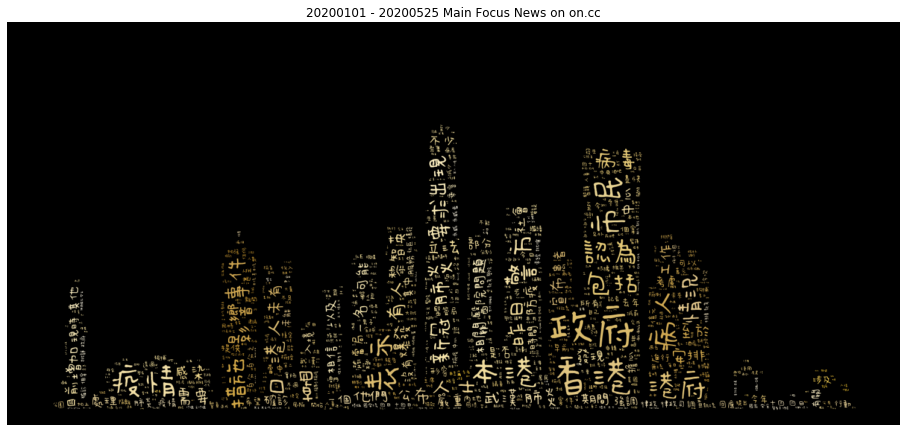

In [8]:
if __name__ == "__main__":
    start_date = input("Enter the start date (yyyymmdd): ")
    end_date = input("Enter the end date (yyyymmdd): ")
    
    if ((start_date != "") and (end_date != "")):
        daterange = pd.date_range(start_date, end_date)
        
        #Download the main focus news
        for news_date in daterange:
            print ('Downloading ' + str(news_date) + ' news...')
            single_news_date = dateConvert(news_date)
            getNews(getNewsLink(single_news_date))
            
        source_text = open('news.txt', 'r',encoding= 'UTF-8').read()
        tokens = ' '.join(jieba.cut_for_search(source_text))
        
        title = str(start_date) + ' - ' + str(end_date) + ' Main Focus News on on.cc'
        
        draw_word_cloud(tokens, 'hongkongpng.png', title)
        